# Video: Modeling Time Series with statsmodels

statsmodel is a Python library developed for econometrics with a variety of statistical tools.
We will use it as a low level time series modeling package for maximum control of the modeling process.

Script:
* The statsmodel Python library was originally developed for work in econometrics.
* It provides a variety statistical tools including hypothesis testing, and it also provides implementations of all the common autoregressive models that we have seen so far.
* Let's get started.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.ar_model as ar_model
import statsmodels.graphics.tsaplots as tsaplots

In [ ]:
boston_data = pd.read_csv("https://github.com/bu-cds-omds/dx704-examples/raw/refs/heads/main/data/boston-temperatures.tsv", sep="\t")

# make date column actual dates and then make it the index
boston_data["date"] = pd.to_datetime(boston_data["date"], format="%Y-%m-%d")
boston_data = boston_data.set_index("date")

Script:
* I already loaded a data set and the statsmodels library and specifically imported two submodules.
* The first one is ar_model for autoregressive models, and the second one is tsaplots for time series analysis plots.
* If you want a different form of time series models, you will need a different model from statsmodels.tsa.
* Before I get started with statsmodels, let's take a look at the data first using our existing tools from pandas and matplotlib.
* As always, you should start with plotting the data to see what it looks like.

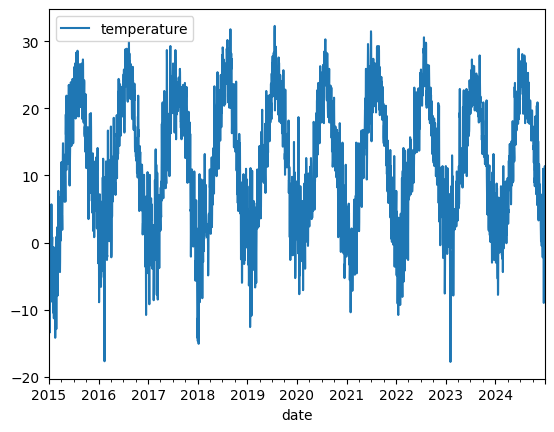

In [ ]:
boston_data.plot();

Script:
* That data looks fine to me.
* To be clear, these measurements are in Celsius, and the data goes through the end of 2025.
* So far, 2025 is looking a bit hotter - we've had a number of days over 35 Celsius this summer.
* Pandas also gives us a few built-in tools for looking at the data as a time series.
* The one I'll show you now is for calculating autocorrelations.

In [ ]:
boston_data["temperature"].autocorr(lag=1)

np.float64(0.9305750824378978)

Script:
* This makes sense as it is comparing consecutive days.

In [ ]:
boston_data["temperature"].autocorr(lag=30)

np.float64(0.7105434680109007)

In [ ]:
boston_data["temperature"].autocorr(lag=365)

np.float64(0.8073385923339392)

Script:
* 30 day and 1 year correlations are lower which is not surprising either.
* Matplotlib also has built-in support for autocorrelation plots, also called correlograms.

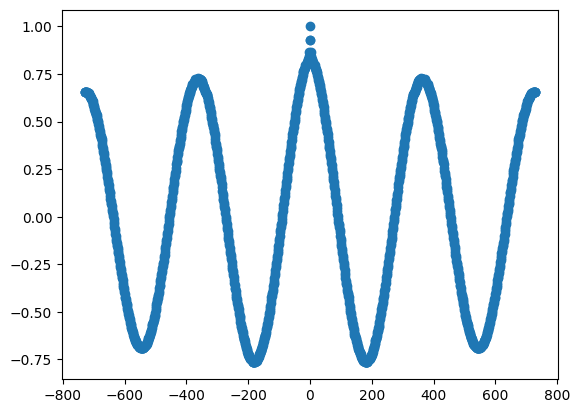

In [ ]:
plt.acorr(boston_data["temperature"] - boston_data["temperature"].mean(), normed=True, maxlags=730, usevlines=False);

Script:
* The x-axis of this plot is centered on zero.
* Depending on the library, you will see them centered like this and always symmetrical, or just showing the right half.
* Also note that the zero lag autocorrelation is shown so the top of the chart will always be consistently high and give you an easier eyeballing of the lower bound.
* You probably also noticed that I subtracted out the mean too; that is because this acorr function assumes that the data is already zero centered.
* That's not everything you can get from pandas and matplotlib, but let's move on to statsmodel now.

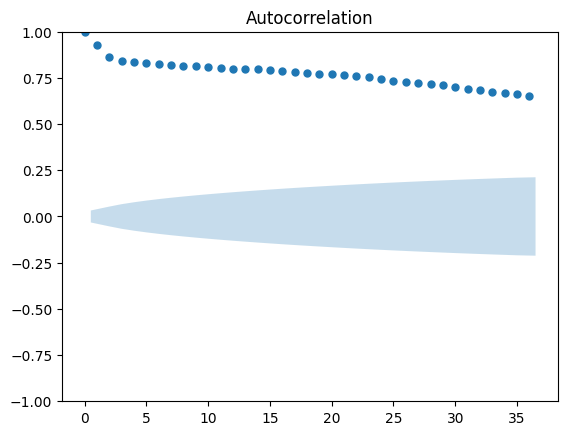

In [ ]:
tsaplots.plot_acf(boston_data["temperature"], use_vlines=False);

Script:
* This `plot_acf` function also plots the autocorrelation, and additionally shows confidence bounds of 2 standard errors as the shaded area below.
* They are wider for the longer lags because there is less data for longer lags.
* If you see the autocorrelations reaching into those confidence bounds, then you should not be confident in the sign of those autocorrelations.
* Let's look at a whole year of lag, since we know that temperature has an annual cycle with the seasons.

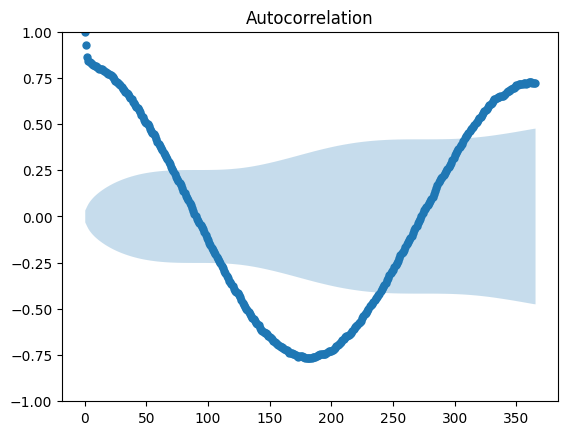

In [ ]:
tsaplots.plot_acf(boston_data["temperature"], lags=365, use_vlines=False);

Script:
* Here, we can see less confidence in those correlations at 60-90 days out.
* Does that make sense?
* 60-90 days ahead is most of a season, and there are season changes in both directions.
* That checks out for me.

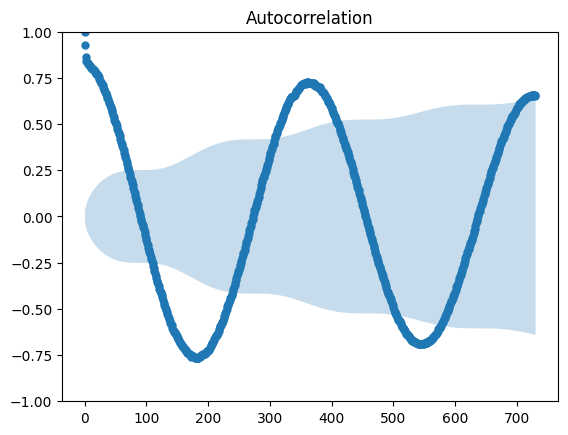

In [ ]:
tsaplots.plot_acf(boston_data["temperature"], lags=365*2, use_vlines=False);

Script:
* Here the autocorrelations are shown out to two years.
* There are not really any surprises here, but note the decreasing autocorrelations as the time lag stretches out.
* I will show you one more chart before moving on to models.

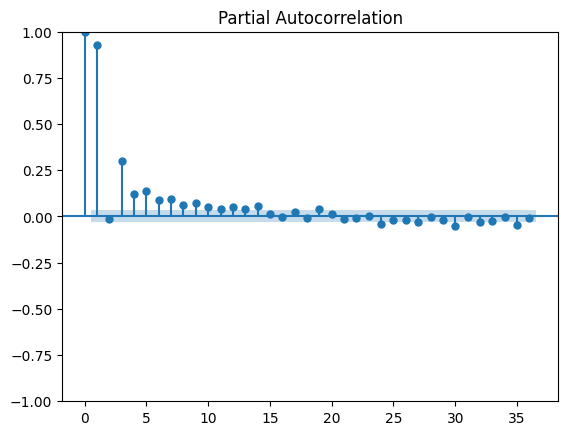

In [ ]:
tsaplots.plot_pacf(boston_data["temperature"]);

Script:
* This is a variation of the autocorrelation chart computing a partial autocorrelation instead.
* Basically, this tries to remove the effects of the shorter lag autocorrelations.
* In this chart, you can see that most of the effect really is from the previous day, and then the influence drops really fast.
* Let's move on to the models now.

In [ ]:
boston_data.index.freq = 'D'

Script:
* One thing that statsmodel wants for its inputs is an indication what time granularity the time series is working at.
* Setting that `freq` attribute to D marks it as daily.

In [ ]:
mod = ar_model.AutoReg(boston_data["temperature"],
                       lags=10,
                       period=365,
                       seasonal=True)
res = mod.fit()

Script:
* This is just a basic autoregressive model.
* Note that the fit model gives us a separate result which is different from the sklearn pattern we have previously seen.
* I set the lag to 10 which covers most of what we saw above in the partial correlations, and setup seasonal patterns with a period of 365.
* Let's make some predictions from this model.

In [ ]:
p = res.predict(len(boston_data), len(boston_data)+365*2)
p

,0
2025-01-01,4.634663
2025-01-02,2.116232
2025-01-03,1.229508
2025-01-04,0.165098
2025-01-05,-0.745219
...,...
2026-12-28,1.830000
2026-12-29,2.400000
2026-12-30,3.850000
2026-12-31,2.510000


Script:
* The inputs to this prediction function are a range of indices from the beginning of the training time series.
* The output includes the second index which is a little different from most range interfaces.
* Note the 731 rows returned for 2 years plus a day.
* Let's plot out those predictions.


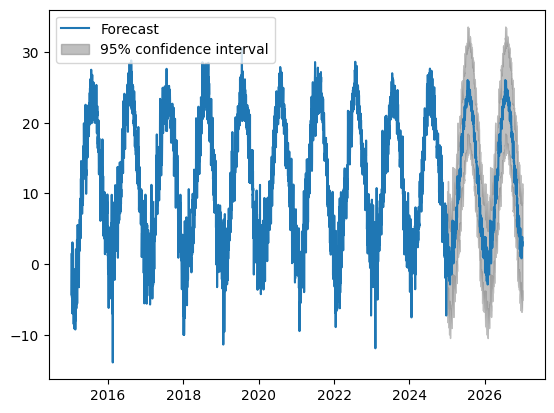

In [ ]:
fig = res.plot_predict(0, len(boston_data)+365*2)

Script:
* All of these values are predictions from the model.
* The values on the right are all in-sample predictions of the model.
* Those with the additional shading on the right are the actual forecasts.
* It would be nice if there was an option to show the original data here, but we can do that easily enough.

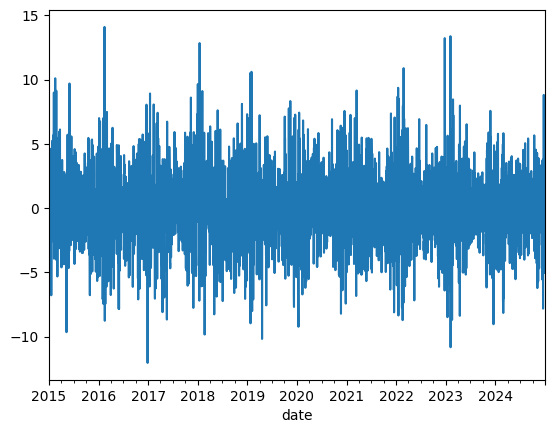

In [ ]:
boston_data["predicted"] = res.predict(0, len(boston_data)-1)
(boston_data["predicted"] - boston_data["temperature"]).plot();

Script:
* So there are some serious gaps in these predictions compared to their training data that weren't obvious just looking at the predictions.
* statsmodel has some built-in diagnostics to look at these a bit more.

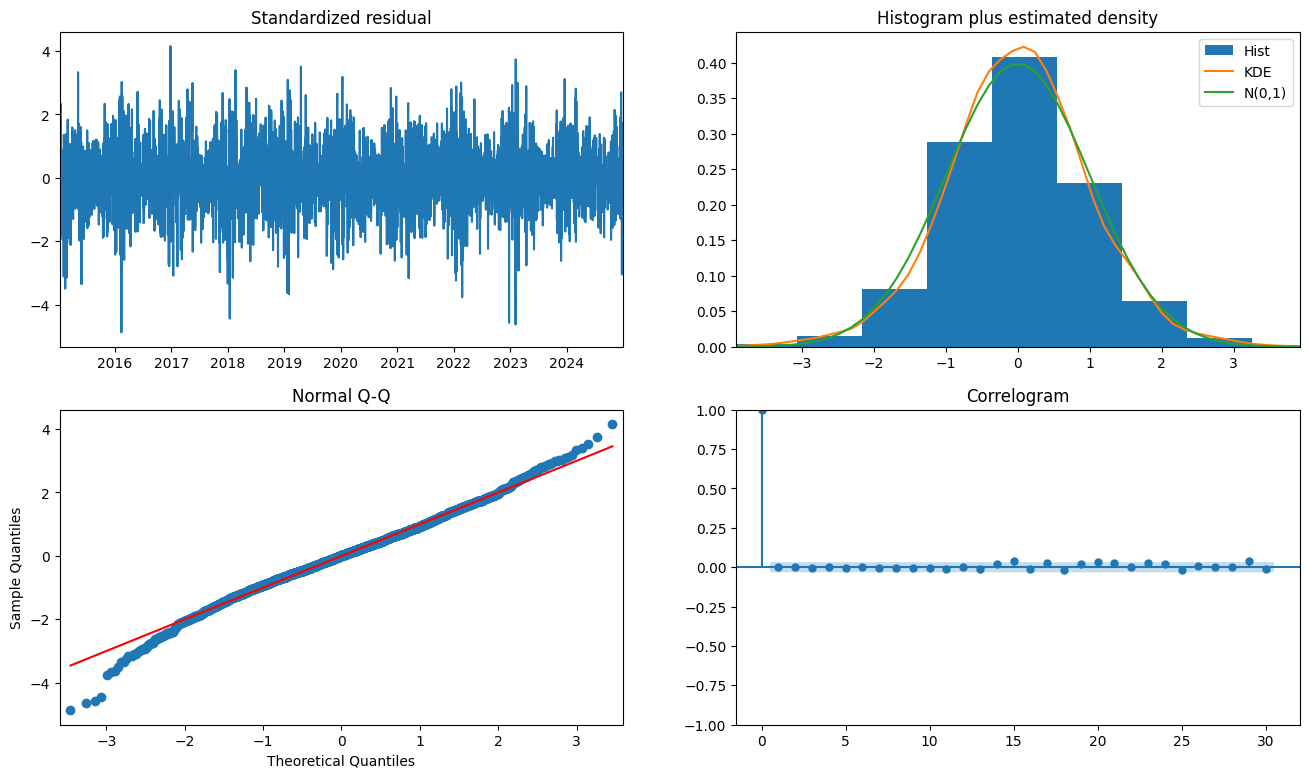

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

Script:
* My take reading these charts is that the model we fit is missing the extreme values and smoothing them out too much.
* That take particularly comes from the Q-Q chart which is matching quantiles from the training data against the quantiles from the model predictions.
* At both ends of the range, we see the highest predictions are not high enough, and the lowest predictions are not low enough.
* That is not uncommon, but something to be aware of.

Script: (faculty on camera)
* That concludes our brief introduction to statsmodel.
* This package has a lot of different kinds of models.
* You can build them similarly to this basic autoregression model with some light tweaks to the imports and some extra parameters building the objects.
* So keep statsmodel in mind when you know what kind of time series model that you want to build.

https://github.com/bu-cds-omds/dx704-examples/blob/main/week02/video_modeling_time_series_with_statsmodels.ipynb